<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v4)
This notebook is the first step towards building up to a real SLAM model.
It focuses on proving out the model architecture, without going into too much w.r.t. proper data generation.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout 63bcc74
!cd repo && git pull

import sys
sys.path.append('repo')

import lds
import map_from_lds_train_data
import slam
from importlib import reload
reload(lds)
reload(map_from_lds_train_data)
reload(slam)

Cloning into 'repo'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 211 (delta 52), reused 59 (delta 41), pack-reused 130 (from 1)
Receiving objects: 100% (211/211), 10.87 MiB | 11.25 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Already up to date.


<module 'slam' from '/content/repo/slam.py'>

In [33]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
from timeit import default_timer as timer

## Helper functions


In [3]:
def display_history(history):
  plt.figure(figsize=(11,3))
  plt.subplot(1,2,1)
  plt.plot(model_history.history["loss"])
  plt.title("Loss")

  plt.subplot(1,2,2)
  plt.plot(model_history.history["accuracy"])
  plt.title("Accuracy")
  plt.show()

def show_prediction(display_list, titles):
    plt.figure(figsize=(10, 3))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

def show_predictions(model, dataset, num=1, show_probs=True):
    """
    Displays the first image of each of the num batches
    """
    for image, ground_truth in dataset.take(num):
        batch = np.expand_dims(image, axis=0)
        batch_pred = model.predict(batch)
        pred = tf.argmax(batch_pred, axis=-1)[0]

        if show_probs:
          # showing full details
          print(f"Class 0 logit range - {tf.reduce_min(batch_pred[..., 0])}, {tf.reduce_max(batch_pred[..., 0])}")
          print(f"Class 1 logit range - {tf.reduce_min(batch_pred[..., 1])}, {tf.reduce_max(batch_pred[..., 1])}")
          #probs = tf.nn.softmax(batch_pred[0], axis=-1)
          probs = batch_pred[0]  # show the raw logits
          class0_prob = probs[:, :, 0]
          class1_prob = probs[:, :, 1]
          show_prediction(
              [image, ground_truth, pred, class0_prob, class1_prob],
              ['LDS Data', 'Ground Truth', 'Predicted', 'Class 0', 'Class 1'])
        else:
          show_prediction([image, ground_truth, pred], ['LDS Data', 'Ground Truth', 'Predicted'])

## Load Floorplan

In [4]:
def one_hot_encode_floorplan(image):
    """
    Converts an RGB floorplan image into a one-hot encoded tensor of the same form
    used as input and output maps in the SLAM model.

    Ordered channels are:
    - floor (white in the RGB image)
    - obstruction (black in the RGB image)
    - unknown (grey in the RGB image)

    Args:
      image: (H,W,3) RGB floorplan image

    Returns:
      (H,W,C) one-hot encoded tensor of the floorplan image
    """
    # sanity check
    if not np.array_equal(np.unique(image), np.array([0, 192, 255])):
      raise ValueError(f"Encountered unexpected values in image, expected [0, 192, 255], got: {np.unique(image)}")

    # get each channel
    floor_mask = tf.reduce_all(tf.equal(image, [255, 255, 255]), axis=-1)
    obstruction_mask = tf.reduce_all(tf.equal(image, [0, 0, 0]), axis=-1)
    unknown_mask = tf.reduce_all(tf.equal(image, [192, 192, 192]), axis=-1)

    # Stack the masks along the last dimension to create a one-hot encoded tensor
    one_hot_image = tf.stack([floor_mask, obstruction_mask, unknown_mask], axis=-1)

    return tf.cast(one_hot_image, tf.float32)

In [5]:
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

floorplan = one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

PIXEL_SIZE = 4.741
MAX_DISTANCE = 350

RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


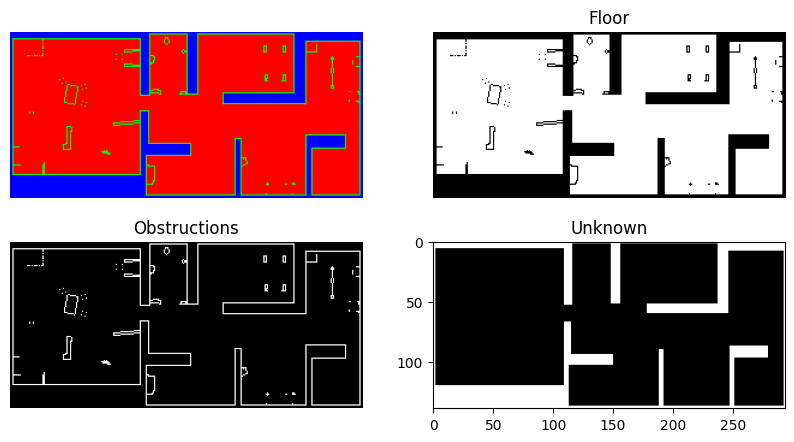

In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(floorplan)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Floor')
plt.imshow(floorplan[:,:,0], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Obstructions')
plt.imshow(floorplan[:,:,1], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Unknown')
plt.imshow(floorplan[:,:,2], cmap='gray')
#plt.axis('off')

## Training data
Here we're going to need to generate new training data. The old training data is in the wrong data structure, uses the wrong encoding for our needs, and used a simple floorplan.

In [28]:
# If generated data is available then load that to save time:
save_path = './experimental-slam-training-data1'
if os.path.exists(save_path):
  train_data = tf.data.Dataset.load(save_path)
print(f"Dataset loaded from {save_path}, len: {len(train_data)}")

Dataset loaded from ./experimental-slam-training-data1, len: 1000


map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.3]


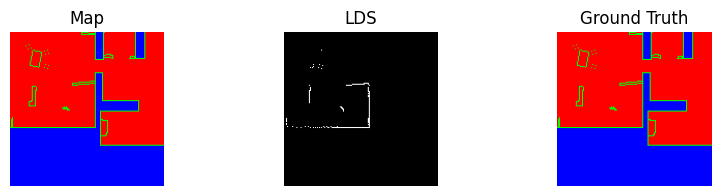

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.3]


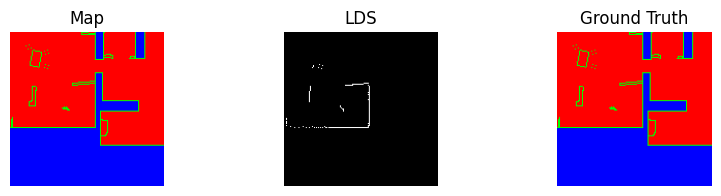

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.3]


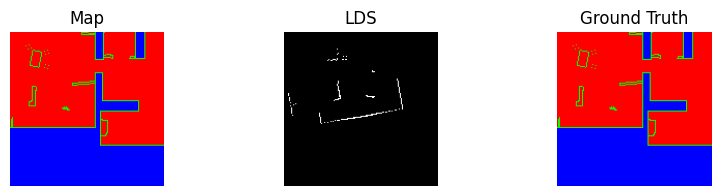

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.3]


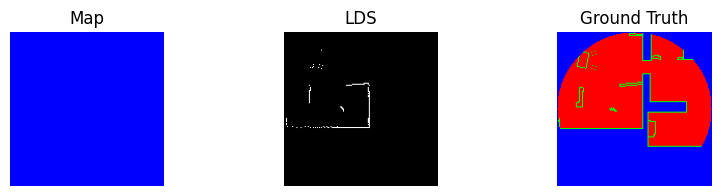

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
centre offset:    [ 0.2 -0.3]


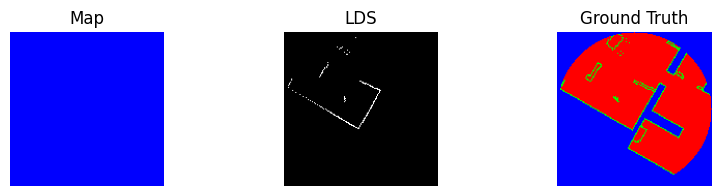

In [8]:
def generate_training_data_sample(semantic_map, location, orientation, map_known, location_error, orientation_error, **kwargs):
    """
    Simulates information that the agent might have and should infer given the agent's true location/orientation
    and the error in its estimate of that location/orientation.

    Can be used to simulate when the agent is moving around an existing known map, by setting map_known=True
    and supplying reasonable location and orientation errors.
    This causes the LDS data to be aligned to the map, depending only on the location and orientation error.
    In this situation, the main orientation parameter only selects where the LDS scan is started from,
    and introduces slight variations in the LDS data collected due to its 1-degree resolution.

    Can be used to simulate when searching the map for the agent's location, by setting orientation_error=np.inf.
    This causes the LDS data to be freely rotated relative to the map.

    Can be used to simulate when the agent has first started in a new area by setting map_known=False,
    in which case the input map is blank and the ground_truth map is rotated to the orientation of the agent.

    :param semantic_map: (H,W,C) = one-hot encoded floorplan
    :param location: (float, float) = (x,y) ground-truth location of agent
    :param orientation: (float) = radians ground-truth angle of orientation of agent
    :param map_known: bool, whether to simulate the agent knowing this section of map or having a blank input map
    :param location_error: None or float tuple, (delta x, deltay).
       Simulates an error on the agent's estimated location. Causes the LDS map to be offset relative to the map,
       in the opposite direction of the error.
       None for no error.
       Generally this should be None if map_known=False.
    :param orientation_error: None or float, radians.
       Simulates an error on the agent's estimated orientation. Causes the LDS map to be rotated relative to the map,
       in the opposite direction of the error.
       None for no error.
       Inf or NaN for unknown orientation, causing the LDS map to be oriented with the true starting angle shifted to zero degrees.
       Generally this should be None if map_known=False.
    :param kwargs:
    :return:
      (input_map, input_lds_image, ground_truth_output_map, ground_truth_output_adlo)
    """
    # config
    max_distance = kwargs.get('max_distance', 100)
    pixel_size = kwargs.get('pixel_size', 1.0)
    #nothing_value = kwargs.get('nothing_value', np.array([1,0,0], dtype=semantic_map.dtype))
    #occupied_value = kwargs.get('occupied_value', np.array([0,1,0], dtype=semantic_map.dtype))
    unknown_value = kwargs.get('unknown_value', np.array([0,0,1], dtype=semantic_map.dtype))
    location_error = np.array(location_error) if location_error is not None else np.array([0.0, 0.0])
    orientation_error = orientation_error if orientation_error is not None else 0.0
    window_size_px = np.ceil(max_distance / pixel_size).astype(int) * 2 + 1
    window_size_px = np.array([window_size_px, window_size_px])
    n_channels = semantic_map.shape[-1]

    #print(f"location: {location} + {location_error}, orientation: {orientation} + {orientation_error}, map_known: {map_known}, pixel_size: {pixel_size}, window_size: {window_size_px}")

    # take LDS sample
    lds_orientation = (orientation + orientation_error) if np.isfinite(orientation_error) else orientation
    ranges = lds.lds_sample(semantic_map[:,:,1], location + location_error, lds_orientation, max_distance=max_distance, pixel_size=pixel_size)
    if (np.nanmax(ranges) < pixel_size) or ranges[~np.isnan(ranges)].size == 0:
        return None, None, None, None

    # generate input map
    # (aligned to map pixels, and zero rotation)
    location_fpx = location / pixel_size  # sub-pixel resolution ("float pixels")
    location_px = np.round(location_fpx).astype(int)
    location_alignment_offset_fpx = location_fpx - location_px  # true centre relative to window centre
    #print(f"window_size: {window_size_px}, location: {location_px} + {location_alignment_offset_fpx} = {location_fpx}")
    if map_known:
      map_window = map_from_lds_train_data.rotated_crop(semantic_map, location_px, 0.0, size=window_size_px, mask='none', pad_value=unknown_value)
    else:
      # all unknown
      map_window = np.tile(unknown_value, (window_size_px[0], window_size_px[1], 1))
    #print(f"map_window: {map_window.shape}")

    # generate ground-truth map
    # (map_known:  aligned to map pixels and zero rotation)
    # (!map_known: aligned to exact centre of window and agent's ground truth orientation)
    if map_known:
      ground_truth_map = map_from_lds_train_data.rotated_crop(semantic_map, location_px, 0.0, size=window_size_px, mask='none', pad_value=unknown_value)
    else:
      ground_truth_map = map_from_lds_train_data.rotated_crop(semantic_map, location_fpx, orientation, size=window_size_px, mask='inner-circle', pad_value=unknown_value)
    #print(f"ground_truth_map: {ground_truth_map.shape}")

    # generate LDS semantic map
    # (oriented according to agent's believed orientation, which omits the orientation_error,
    #  and is 0.0 if completely unknown)
    believed_orientation = orientation if map_known and np.isfinite(orientation_error) else 0.0
    lds_map = lds_to_occupancy_map(ranges, start_angle=believed_orientation, size_px=window_size_px, centre_px=location_alignment_offset_fpx, pixel_size=pixel_size)

    return map_window, lds_map, ground_truth_map, location_alignment_offset_fpx

def lds_to_occupancy_map(ranges, start_angle, size_px, **kwargs):
    """
    :param ranges: array (n,) - range values may contain nans, which are dropped
    :param start_angle: angle of first range (radians)
    :param centre_px: array (2,) = float, [x,y] - centre point for ranges
    :param size_px: int/float or tuple (h, w) = size of output map in pixels
    :param kwargs

    Keyword args:
      pixel_size:
      centre_px: tuple, float (x,y), relative to map centre (unit: pixels)
        Usually centres LDS data exactly on centre of generated map (to sub-pixel resolution).
        Use this to shift by some amount.
      encoding: one of 'nn', 'antialiased', 'nn+offset':
        nn: nearest neighbour
        (TODO) antialised: blurs into adjacent pixels for implied sub-pixel resolution
        (TODO) nn+offset: picks single NN pixel, but on second and third channels adds
          x and y offset (-0.5 .. +0.5) in sub-pixel resolution

    :return: array (h,w) of floats in range [0,1]
    """

    # config
    pixel_size = kwargs.get('pixel_size', 1.0)
    centre_px = kwargs.get('centre_px', (0.0, 0.0))
    size_px = np.array(size_px) if len(size_px) == 2 else np.array([size_px, size_px])

    map_centre_fpx = np.array((size_px-1) / 2) + np.array(centre_px)

    #print(f"pixel_size: {pixel_size}, centre_px: {centre_px}, map_centre_fpx: {map_centre_fpx}")

    lds_points = lds.lds_to_2d(ranges, (0, 0), start_angle)
    lds_points_px = np.round(lds_points/pixel_size + map_centre_fpx).astype(int)
    lds_map = np.full(size_px, 0.0, dtype=np.float32)
    lds_map[lds_points_px[:,1], lds_points_px[:,0]] = 1.0

    return lds_map

def display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset):
  print(f"map_window:       {map_window.shape}")
  print(f"lds_map:          {lds_map.shape}")
  print(f"ground_truth_map: {ground_truth_map.shape}")
  print(f"centre offset:    {centre_offset}")

  plt.figure(figsize=(10, 2))

  plt.subplot(1, 3, 1)
  plt.title('Map')
  plt.imshow(map_window)
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title('LDS')
  plt.imshow(lds_map, cmap='gray')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title('Ground Truth')
  plt.imshow(ground_truth_map, cmap='gray')
  plt.axis('off')
  plt.show()


reload(map_from_lds_train_data)
pixel_size = 4.741
location = np.array([100.2, 100.7]) * pixel_size
window_size = np.ceil(350 / pixel_size).astype(int) * 2 + 1

# perfect example
map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, 0.0, True, (0,0), 0, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

# different orientation
map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, np.deg2rad(30.5), True, (0,0), 0, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

# estimation error
map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, 0.0, True, (-150.0, +50.0), np.deg2rad(-10.0), pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

# map unknown - facing one way
map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, 0.0, False, None, None, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

# map unknown - facing a different way
map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, location, np.deg2rad(30.0), False, None, None, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

In [ ]:
loc = np.array([ 82.40540193 , 248.21413008])
angle = 2.2490386454166282
#ranges = lds.lds_sample(floorplan[:,:,1], loc, angle, max_distance=350, pixel_size=4.741)

map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(floorplan, loc, angle, False, None, None, pixel_size=pixel_size, max_distance=350)
display_training_data_sample(map_window, lds_map, ground_truth_map, centre_offset)

In [19]:
def generate_training_data(semantic_map, num_samples, **kwargs):
    pixel_size = kwargs.get('pixel_size', PIXEL_SIZE)
    max_distance = kwargs.get('max_distance', MAX_DISTANCE)

    # identify ranges
    # - size of full map (W, H), physical units
    # - size of window (W, H), physical units
    full_map_loc_range = np.array([semantic_map.shape[1], semantic_map.shape[0]]) * pixel_size
    window_size = (np.ceil(max_distance / pixel_size).astype(int) * 2 + 1) * pixel_size
    window_range = np.array([window_size, window_size])

    input_maps = []
    lds_maps = []
    ground_truth_maps = []
    adlos = []
    attempts = 0
    for _ in tqdm.tqdm(range(num_samples)):
        # keep trying until we generate one sample
        while True:
            attempts += 1
            sample_type = np.random.randint(4)
            location = np.random.uniform((0,0), full_map_loc_range)
            angle = np.random.uniform(-np.pi, np.pi)
            accept = True
            loc_error = (0.0, 0.0)
            angle_error = 0.0
            #print(f"sample_type: {sample_type}, loc_range: {loc_range}, location: {location}, angle: {angle}")

            if sample_type == 0:
              # New map, unknown location and orientation, loc/angle error disregarded
              map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(
                  floorplan, location, angle, False, None, None, pixel_size=pixel_size, max_distance=max_distance)

            elif sample_type == 1:
              # Known map, known location/angle with some small uniform estimation error
              loc_error = np.random.normal((0,0), window_range/2 * 0.1)  # normal about centre, std.dev = 10% of range
              angle_error = np.random.uniform(0, np.pi * 0.1)            # normal about zero, std.dev = 10% of 180 degrees
              loc_error = np.clip(loc_error, -window_range/2, +window_range/2)
              angle_error = np.clip(angle_error, -np.pi, +np.pi)
              map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(
                  floorplan, location, angle, True, loc_error, angle_error, pixel_size=pixel_size, max_distance=max_distance)

            elif sample_type == 3:
              # Known map, location unknown and searching, with LDS data partially on this map window.
              # Location of map window independent of LDS data so simulate using uniform location and
              # orientation error within bounds of the window
              loc_error = np.random.uniform(-window_range/2, +window_range/2)  # uniform either side of zero, anywhere within window
              angle_error = np.random.uniform(-np.pi, np.pi)                   # uniform anywhere within 360-degree range
              map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(
                  floorplan, location, angle, True, loc_error, angle_error, pixel_size=pixel_size, max_distance=max_distance)

            elif sample_type == 4:
              # Known map, location unknown and searching, with LDS not on this map window.
              # Generate LDS from completely independent random location/orientation within full map
              # (TODO use some smarts to pick a location that is a full max_distance diameter away but still on the floorplan)
              lds_loc = np.random.uniform((0,0), full_map_loc_range)     # uniform anywhere within full map
              lds_angle = np.random.uniform(-np.pi, np.pi)               # uniform anywhere within 360-degree range
              loc_error = lds_loc - location
              angle_error = lds_angle - angle
              map_window, lds_map, ground_truth_map, centre_offset = generate_training_data_sample(
                  floorplan, location, angle, True, loc_error, angle_error, pixel_size=pixel_size, max_distance=max_distance)
              # for expected NN outputs
              accept = False
              loc_error = (0, 0)  # error is ignored by loss function, but if we care then we'd prefer the NN doesn't claim there's a loc error
              angle_error = 0     # error is ignored by loss function, but if we care then we'd prefer the NN doesn't claim there's an orientation error

            # emit results
            if lds_map is not None:
              adlo = np.array([
                  1.0 if accept else 0.0,
                  loc_error[0] / window_range[0],   # convert to range: -0.5 .. +0.5
                  loc_error[1] / window_range[1],   # convert to range: -0.5 .. +0.5
                  angle_error / np.pi               # convert to range: -1.0 .. +1.0
              ])

              input_maps.append(map_window)
              lds_maps.append(lds_map)
              ground_truth_maps.append(ground_truth_map)
              adlos.append(adlo)
              break

    print(f"Done, after {attempts} attempts")
    return tf.data.Dataset.from_tensor_slices((
        (input_maps, lds_maps),
        (ground_truth_maps, adlos)
    ))

np.random.seed(0)
train_data = generate_training_data(floorplan, 1000)

# Sanity check generated data
def assert_in_range(name, tensor, allowed_min, allowed_max):
  if np.min(tensor) < allowed_min or np.max(tensor) > allowed_max:
    raise ValueError(f"{name} has values outside of desired range, found: {np.min(tensor)}-{np.max(tensor)}")

for (map_window, lds_map), (ground_truth_map, adlo) in train_data:
  assert_in_range("map_window", map_window, 0.0, 1.0)
  assert_in_range("lds_map", map_window, 0.0, 1.0)
  assert_in_range("ground_truth_map", map_window, 0.0, 1.0)
  assert_in_range("accept", adlo[0], 0.0, 1.0)
  assert_in_range("loc-x", adlo[1], -0.5, 0.5)
  assert_in_range("loc-y", adlo[2], -0.5, 0.5)
  assert_in_range("orientation", adlo[3], -1.0, 1.0)
print("Dataset tests passed")

 14%|█▎        | 136/1000 [00:07<01:17, 11.18it/s]<ipython-input-8-c9f9aa38eff5>:54: RuntimeWarning: All-NaN slice encountered
  if (np.nanmax(ranges) < pixel_size) or ranges[~np.isnan(ranges)].size == 0:
100%|██████████| 1000/1000 [00:56<00:00, 17.55it/s]


Done, after 1016 attempts
Dataset tests passed


In [37]:
# Save for later re-loading
# (needs to be manually downloaded and saved to repo)
#np.savez_compressed('experimental-slam-training-data1.npz', train_data)

save_path = 'experimental-slam-training-data1'
if os.path.exists(save_path):
  shutil.rmtree(save_path)
  print(f"Removed existing {save_path}")
os.makedirs(save_path, exist_ok=True)
train_data.save(save_path)
print(f"Dataset saved to {save_path}")

# tf.Dataset.save() seems to do stuff in parallel in the background, or perhaps it's something
# to do with the disk provided in the colab environment, so wait for the shard files to be written
def wait_for_shards(directory, timeout=30):
    print("Waiting for shards to appear on disk...")
    start_time = time.time()
    while True:
        # Check if the directory contains the expected shard files
        files = os.listdir(directory)
        if all("part-" in file for file in files) and len(files) > 0:
            print("Shard files detected.")
            break
        if time.time() - start_time > timeout:
            raise TimeoutError("Shard files not fully written within the timeout period.")
        time.sleep(1)

wait_for_shards(save_path)
#save_file = 'experimental-slam-training-data1.tar.gz'
#with tarfile.open(save_file, "w:gz") as tar:
#    tar.add(save_path, arcname=os.path.basename(save_path))
#print(f"Compressed dataset directory to: {save_file}")

Removed existing experimental-slam-training-data1
Dataset saved to experimental-slam-training-data1
Waiting for shards to appear on disk...


KeyboardInterrupt: 

In [40]:
!ls -lr experimental-slam-training-data1


total 12
-rw-r--r-- 1 root root   42 Oct 25 03:11 snapshot.metadata
-rw-r--r-- 1 root root   91 Oct 25 03:11 dataset_spec.pb
drwxr-xr-x 2 root root 4096 Oct 25 03:11 12588291604328213036


map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [1. 0. 0. 0.]


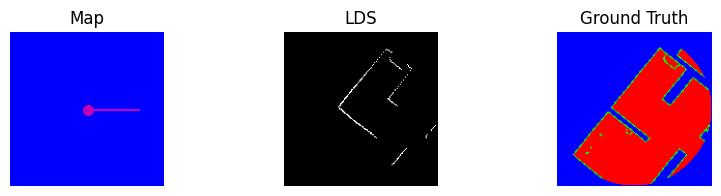

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [ 1.          0.391773    0.46366276 -0.23311696]


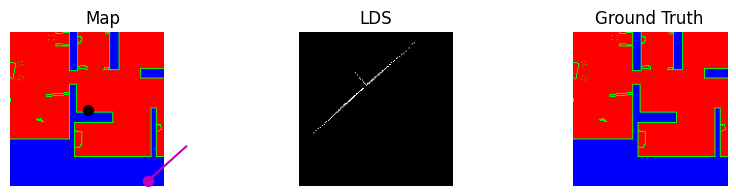

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [1. 0. 0. 0.]


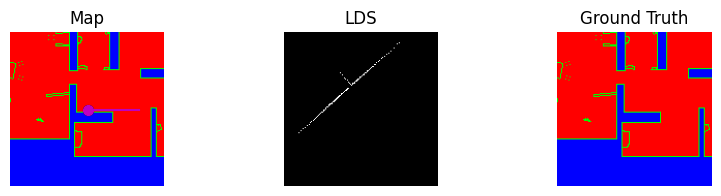

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [1.         0.02421561 0.02895702 0.08700121]


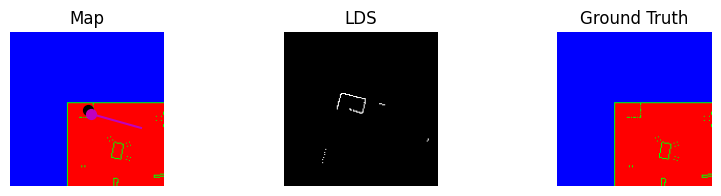

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [1. 0. 0. 0.]


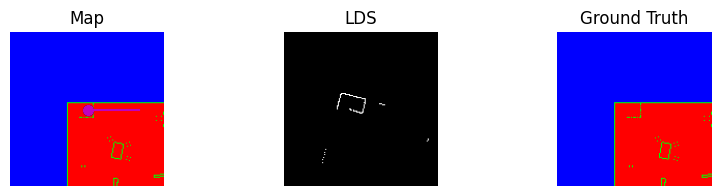

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [ 1.          0.44466892  0.02184832 -0.17067612]


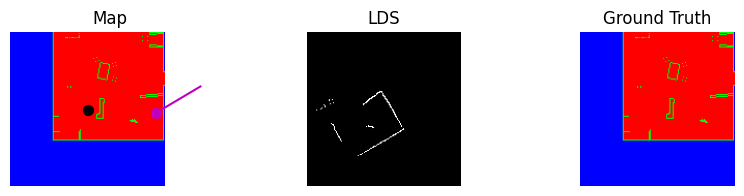

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [ 1.         -0.36478183 -0.17585899 -0.70065027]


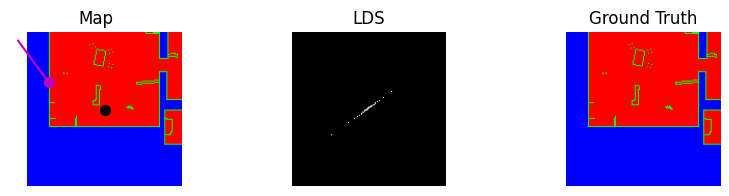

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [1. 0. 0. 0.]


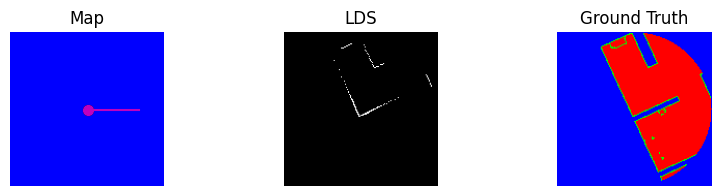

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [1. 0. 0. 0.]


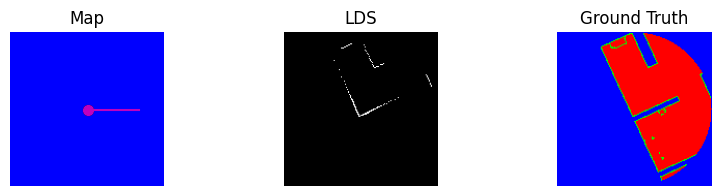

map_window:       (149, 149, 3)
lds_map:          (149, 149)
ground_truth_map: (149, 149, 3)
adlo:             [ 1.         -0.01929317 -0.03878812  0.03637108]


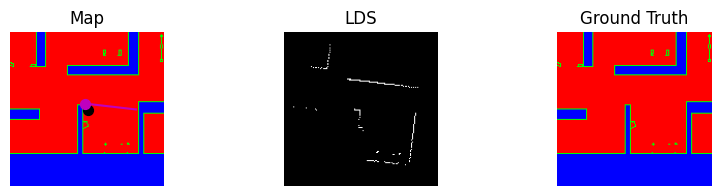

In [18]:
# There's clearly a problem with its level of randomness, but otherwise it's basically working now
def add_to_plot(map_window, lds_map, ground_truth_map, adlo, pixel_size):
  print(f"map_window:       {map_window.shape}")
  print(f"lds_map:          {lds_map.shape}")
  print(f"ground_truth_map: {ground_truth_map.shape}")
  print(f"adlo:             {adlo}")

  range = np.array([map_window.shape[1], map_window.shape[0]])
  centre = range / 2
  error_loc = centre + adlo[1:3]*range
  angle_loc = error_loc + np.array([np.cos(adlo[3]*np.pi), np.sin(adlo[3]*np.pi)])*50

  plt.figure(figsize=(10,2))
  plt.subplot(1, 3, 1)
  plt.title('Map')
  plt.imshow(map_window)
  plt.axis('off')
  plt.plot([error_loc[0], angle_loc[0]], [error_loc[1], angle_loc[1]], c='m')
  plt.scatter(centre[0], centre[1], c='k', s=50)
  plt.scatter(error_loc[0], error_loc[1], c='m', s=50)

  plt.subplot(1, 3, 2)
  plt.title('LDS')
  plt.imshow(lds_map, cmap='gray')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title('Ground Truth')
  plt.imshow(ground_truth_map, cmap='gray')
  plt.axis('off')
  plt.show()

# show first 5
for (map_window, lds_map), (ground_truth_map, adlo) in train_data.take(10):
  add_to_plot(map_window, lds_map, ground_truth_map, adlo, PIXEL_SIZE)

## Model training

In [ ]:
one = next(iter(train_data))
print(f"one: {type(one)} with {len(one)} x {type(one[0])}")
print(f"one[0]: {type(one[0])} with {len(one[0])} of {type(one[0][0])}")
print(f"one[0][0]: {one[0][0].shape}")
print(f"one[0][1]: {one[0][1].shape}")
print(f"one[0]: {type(one[1])} with {len(one[1])} of {type(one[1][0])}")
print(f"one[1][0]: {one[1][0].shape}")
print(f"one[1][1]: {one[1][1].shape}")

In [ ]:
reload(slam)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

In [ ]:
# Custom loss functions
def map_only(y_trues, y_preds):
    y_trues = tf.one_hot(tf.cast(y_trues, tf.uint8), y_preds.shape[-1])
    y_preds = tf.nn.softmax(y_preds)
    losses = tf.keras.losses.categorical_crossentropy(y_trues, y_preds)
    return tf.reduce_mean(losses)

reload(slam)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              loss=map_only,
              metrics=['accuracy', 'accuracy'])

epochs = 5
batch_size = 32
model_train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
#display_history(model_history)
#show_predictions(model, dataset, 5)

map_shape: (149, 149, 3)
Map shape: (149, 149, 3) + padding (11, 11, 0)
Skip-connection merge mode: concat
Output: logits
Added final cropping layer: w=11, h=11
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - cropping2d_18_accuracy: 0.4386 - dense_56_accuracy: 0.2283 - loss: -42714.8164
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - cropping2d_18_accuracy: 0.4926 - dense_56_accuracy: 0.2264 - loss: 90007960.0000
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - cropping2d_18_accuracy: 0.5077 - dense_56_accuracy: 0.2347 - loss: 15322975232.0000
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - cropping2d_18_accuracy: 0.4690 - dense_56_accuracy: 0.2191 - loss: 404048609280.0000
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - cropping2d_18_accuracy: 0.4975 - dense_56_accuracy: 0.2014 - loss: 9299624460288.0000
Epochs: 5, duration: 29.324874707999697 sec
